<table>
 <tr align=left><td><img align=left src="./images/CC-BY.png">
 <td>Text provided under a Creative Commons Attribution license, CC-BY. All code is made available under the FSF-approved MIT license. (c) Kyle T. Mandli</td>
</table>

In [10]:
from __future__ import print_function

%matplotlib inline
import numpy
import matplotlib.pyplot as plt
import matplotlib.animation

import os
import pyclaw
path = os.path.join(os.environ.get("CLAW", os.getcwd()), "pyclaw", "fvmbook", "chap6")
os.chdir(path)
import advection

# High-Resolution Methods

The general approach we will take to augmenting our wave propagation methodology is to add correction terms in the following way:
$$
    Q^{n+1}_i = Q^n_i - \frac{\Delta t}{\Delta x} \left (\mathcal{A}^+_{i-1/2} + \mathcal{A}^-_{i+1/2}  \right) - \frac{\Delta t}{\Delta x} \left (\widetilde{F}_{i+1/2} - \widetilde{F}_{i-1/2} \right)
$$
where here we have written these corrections as fluxes.

## Lax-Wendroff Method

The first approach we will investigate is the Lax-Wendroff method derived from a Taylor series approach.  Recall that the taylor series of our solution has the form
$$
    q(x, t_{n+1}) = q(x, t_n) + \Delta t q_t(x, t_n) + \frac{1}{2} \Delta t^2 q_{tt}(x, t_n) + \ldots
$$
If we consider solving the linear advection problem $q_t + A q_x = 0$ and assume *smooth solutions* then we can replace time derivatives with spatial derivaties in our taylor series above where $q_t = -A q_x$ to find
$$
    q(x, t_{n+1}) = q(x, t_n) - \Delta t A q_x(x, t_n) + \frac{1}{2} \Delta t^2 q_{tt}(x, t_n) + \ldots
$$

Taking the second time derivative of $q_t = -A q_x$ leads to
$$\begin{aligned}
    \frac{\partial}{\partial t} (q_t) =& \frac{\partial}{\partial t}(-A q_x) \\
    q_{tt} =& -A (q_x)_t \\
    q_{tt} =&  A^2 q_{xx}.
\end{aligned}$$
Plugging this in again into our Taylor series we now have
$$
    q(x, t_{n+1}) = q(x, t_n) - \Delta t A q_x(x, t_n) + \frac{1}{2} \Delta t^2 A^2 q_{xx}(x, t_n) + \ldots
$$

Replacing the spatial derivatives with second order finite differences then leads us to the Lax-Wendroff method
$$
    Q^{n+1}_i = Q^n_i - \frac{\Delta t}{2 \Delta x} (Q^n_{i+1} - Q^n_{i-1}) + \frac{1}{2} \left(\frac{\Delta t}{\Delta x}\right)^2 A^2 (Q^n_{i+1} - Q^n_i + Q^n_{i-1}).
$$

This can again be interpreted as a finite volume method with the flux function defined as
$$
    F^n_{i-1/2} =\frac{1}{2} A (Q^n_{i-1} + Q^n_i) - \frac{1}{2} \frac{\Delta t}{\Delta x} A^2 (Q^n_i - Q^n_{i-1})
$$
As mentioned before this looks like the unstable flux with a diffusive correction term.  From a method of lines and absolute stablity point-of-view this is exactly what pushed the eigenvalues into the absolute stability region of forward Euler.

2019-09-30 09:42:26,793 INFO CLAW: Solution 0 computed for time t=0.000000
2019-09-30 09:42:26,807 INFO CLAW: Solution 1 computed for time t=1.000000
2019-09-30 09:42:26,820 INFO CLAW: Solution 2 computed for time t=2.000000
2019-09-30 09:42:26,831 INFO CLAW: Solution 3 computed for time t=3.000000
2019-09-30 09:42:26,845 INFO CLAW: Solution 4 computed for time t=4.000000
2019-09-30 09:42:26,857 INFO CLAW: Solution 5 computed for time t=5.000000
2019-09-30 09:42:26,871 INFO CLAW: Solution 6 computed for time t=6.000000
2019-09-30 09:42:26,885 INFO CLAW: Solution 7 computed for time t=7.000000
2019-09-30 09:42:26,899 INFO CLAW: Solution 8 computed for time t=8.000000
2019-09-30 09:42:26,914 INFO CLAW: Solution 9 computed for time t=9.000000
2019-09-30 09:42:26,929 INFO CLAW: Solution 10 computed for time t=10.000000


StopIteration: 

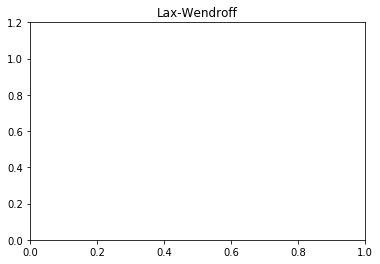

In [11]:
claw = advection.fig_61_62_63(solver_order=2, limiters=0)
claw.run()

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.set_xlim((0, 1))
axes.set_ylim((0, 1.2))
axes.set_title("Lax-Wendroff")
line = axes.plot([], [])

def fplot(frame_number):
    x = frames[0].p_center[0]
    for (n, frame) in enumerate(claw.frames):
        line.set_data(x, frame.q[0, :])
    return line,

anim = matplotlib.animation.FuncAnimation(fig, fplot, frames=len(claw.frames), interval=30)
HTML(anim.to_jshtml())

## Beam-Warming Method
Another approach to second order accuracy is to instead use one-sided or upwinded derivative approximations.  With the same Taylor series approach if we instead replace the spatial derivatives with upwinded differences we then have
$$\begin{aligned}
    q_x(x_i,t_n) &= \frac{1}{2\Delta x} [3 q(x_i, t_n) - 4q(x_{i-1}, t_n) + q(x_{i-2}, t_n)] + \mathcal{O}(\Delta x^2) \\
    q_{xx}(x_i,t_n) &= \frac{1}{\Delta x^2} [q(x_i, t_n) - 2q(x_{i-1}, t_n) + q(x_{i-2}, t_n)] + \mathcal{O}(\Delta x^2) \\
\end{aligned}$$
leading to
$$
    Q^{n+1}_i = Q^n_i - \frac{\Delta t}{2 \Delta x} A (3 Q^n_i - 4 Q^n_{i-1} + Q^n_{i-2} ) + \frac{1}{2} \left(\frac{\Delta t}{\Delta z} \right)^2 A^2 (Q^n - 2 Q^n_{i-1} + Q^n_{i-2})
$$
or in flux form
$$
    F^n_{i-1/2} = A Q^n_{i-1} + \frac{1}{2} A \left ( 1 - \frac{\Delta t}{\Delta x} A \right) (Q^n_{i-1} - Q^n_{i-2}).
$$

## Preview of Limiters

2019-09-30 09:43:34,406 INFO CLAW: Solution 0 computed for time t=0.000000
2019-09-30 09:43:34,420 INFO CLAW: Solution 1 computed for time t=1.000000
2019-09-30 09:43:34,434 INFO CLAW: Solution 2 computed for time t=2.000000
2019-09-30 09:43:34,446 INFO CLAW: Solution 3 computed for time t=3.000000
2019-09-30 09:43:34,460 INFO CLAW: Solution 4 computed for time t=4.000000
2019-09-30 09:43:34,474 INFO CLAW: Solution 5 computed for time t=5.000000
2019-09-30 09:43:34,489 INFO CLAW: Solution 6 computed for time t=6.000000
2019-09-30 09:43:34,506 INFO CLAW: Solution 7 computed for time t=7.000000
2019-09-30 09:43:34,522 INFO CLAW: Solution 8 computed for time t=8.000000
2019-09-30 09:43:34,538 INFO CLAW: Solution 9 computed for time t=9.000000
2019-09-30 09:43:34,554 INFO CLAW: Solution 10 computed for time t=10.000000


StopIteration: 

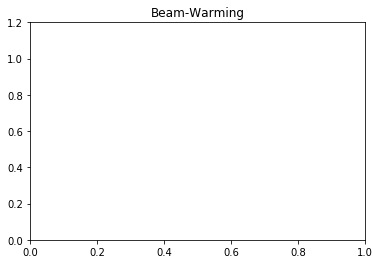

In [13]:
### Compare several methods for advecting a Gaussian and square wave.
### 
### The settings coded here are for Figure 6.1(a).
### For Figure 6.1(b), set solver.order=2.
### For Figure 6.2(a), set solver.order=2 and solver.limiters = pyclaw.limiters.tvd.minmod (1)
### For Figure 6.2(b), set solver.order=2 and solver.limiters = pyclaw.limiters.tvd.superbee (2)
### For Figure 6.2(c), set solver.order=2 and solver.limiters = pyclaw.limiters.tvd.MC (4)
### 
### For Figure 6.3, set IC='wavepacket' and other options as appropriate.
claw = advection.fig_61_62_63(solver_order=2, limiters=1)
claw.run()

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.set_xlim((0, 1))
axes.set_ylim((0, 1.2))
axes.set_title("Beam-Warming")
line = axes.plot([], [])

def fplot(frame_number):
    x = frames[0].p_center[0]
    for (n, frame) in enumerate(claw.frames):
        line.set_data(x, frame.q[0, :])
    return line,

anim = matplotlib.animation.FuncAnimation(fig, fplot, frames=len(claw.frames), interval=30)
HTML(anim.to_jshtml())

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots()
xdata, ydata = [], []
ln, = plt.plot([], [], 'ro')

def init():
    ax.set_xlim(0, 2*np.pi)
    ax.set_ylim(-1, 1)
    return ln,

def update(frame):
    xdata.append(frame)
    ydata.append(np.sin(frame))
    ln.set_data(xdata, ydata)
    return ln,

anim = FuncAnimation(fig, update, frames=np.linspace(0, 2*np.pi, 128),
                     init_func=init, blit=True)
plt.close()
HTML(anim.to_jshtml())

## The REA Algorithm with Piecewise Linear Reconstruction

## Choice of Slopes

## Oscillations

## Total Variation

**Total Variation Diminishing**

## Slope-Limiter Methods

## Flux Formulation with Piecewise Linear Reconstruction

## Flux Limiters

## TVD Limiters

## Methods for Systems

## Wave-Propagation Implementation

## Non-Linear Systems